In [265]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold
import lightgbm as lgbm# .loc[df_test.sku_name == new_id_test[0]]
from sklearn.preprocessing import LabelEncoder as LE
import seaborn as sns
import scipy.stats as ss
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import seaborn as sns
from matplotlib import pyplot as plt
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:50]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [266]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
dict_s = pd.read_csv('DataDictionary.csv')


In [267]:
# test
add_weeks = False
add_pivotal_sum = False
add_pivotal_max = False
encode_channels = False
add_pivotal_min = False
add_kmeans = False
# enode_channels = False
add_similar_month = False
import calendar
def count_weekends(m,y):
    day_to_count = calendar.SUNDAY

    matrix = calendar.monthcalendar(y,m)

    num_days = sum(1 for x in matrix if x[day_to_count] != 0)
    return num_days%4
if add_weeks:
    test['Weeks'] = test.apply(lambda x: count_weekends(x.month, x.year), axis=1)


In [268]:
df_train = train.copy()
df_test = test.copy()
target = 'sellin'
prediction_columns = test.columns.tolist()
encoding_columns = [t for t in train.columns if t not in prediction_columns]
sellin = ['sellin','sellin_channel_1','sellin_channel_2','sellin_channel_3','sellin_channel_4',
         'sellin_channel_5','sellin_channel_6','sellin_channel_7','sellin_channel_8']
sellout = ['sellout','sellout_channel_1','sellout_channel_2','sellout_channel_3','sellout_channel_4',
         'sellout_channel_5','sellout_channel_6','sellout_channel_7','sellout_channel_8','sellout_channel_9',
           'sellout_channel_10']
onhand= ['onhand_inventory','onhand_inventory_channel_1','onhand_inventory_channel_2','onhand_inventory_channel_3','onhand_inventory_channel_4',
         'onhand_inventory_channel_5','onhand_inventory_channel_6','onhand_inventory_channel_7','onhand_inventory_channel_8','onhand_inventory_channel_9',
           'onhand_inventory_channel_10']
pivotal_sum_fea = ['sku_name_target_enc_sum_month_'+str(i+1) for i in range(12) ]
pivotal_min_fea = ['sku_name_target_enc_min_month_'+str(i+1) for i in range(12) ]
pivotal_max_fea = ['sku_name_target_enc_max_month_'+str(i+1) for i in range(12) ]
pivot_fea = pivotal_sum_fea + pivotal_max_fea + pivotal_min_fea
# new_fea = [f for f in X_train.columns if f not in pivot_fea ]
price_enc =  ['sku_namepriceenc6','sku_namepriceenc5','sku_namepriceenc4','sku_namepriceenc','sku_namepriceenc1','sku_namepriceenc2','sku_namepriceenc3']
sellin_enc =  ['sku_namesellinenc6','sku_namesellinenc5','sku_namesellinenc4','sku_namesellinenc','sku_namesellinenc1','sku_namesellinenc2','sku_namesellinenc3']
sellout_enc =  ['sku_nameselloutenc6','sku_nameselloutenc5','sku_nameselloutenc4','sku_nameselloutenc','sku_nameselloutenc1','sku_nameselloutenc2','sku_nameselloutenc3']
onhand_inventory_enc =  ['sku_nameonhand_inventoryenc6','sku_nameonhand_inventoryenc5','sku_nameonhand_inventoryenc4','sku_nameonhand_inventoryenc','sku_nameonhand_inventoryenc1','sku_nameonhand_inventoryenc2','sku_nameonhand_inventoryenc3']
starting_inventory_enc =  ['sku_namestarting_inventoryenc6','sku_namestarting_inventoryenc5','sku_namestarting_inventoryenc4','sku_namestarting_inventoryenc','sku_namestarting_inventoryenc1','sku_namestarting_inventoryenc2','sku_namestarting_inventoryenc3']
enc_features = price_enc + sellin_enc + sellout_enc + onhand_inventory_enc + starting_inventory_enc 
df_train['price0'] = df_train['price']//100
df_train['price1'] = (df_train['price']//10)%10
df_train['price2'] = df_train['price']%10
df_train['price3'] = df_train['price']//10
df_train[sellin+sellout+onhand+['leftover_inventory','starting_inventory']] = df_train[sellin+sellout+onhand+['leftover_inventory','starting_inventory']]/1013


In [269]:
def target_encode(df_train,df_test,target):
    sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
    sku_name_target_max = df_train.groupby('sku_name')[target].max()
    sku_name_target_min = df_train.groupby('sku_name')[target].min()
    sku_name_target_std = df_train.groupby('sku_name')[target].std()
    sku_name_target_median = df_train.groupby('sku_name')[target].apply(lambda x : np.median(x))
    sku_name_target_q95 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95))
    sku_name_target_q05 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05))
    # sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
    df_test['sku_name'+target+'enc'] = df_test['sku_name'].map(sku_name_target_mean)
    df_test['sku_name'+target+'enc'].fillna((df_test['sku_name'+target+'enc'].mean()), inplace=True)
    df_test['sku_name'+target+'enc1'] = df_test['sku_name'].map(sku_name_target_max)
    df_test['sku_name'+target+'enc1'].fillna((df_test['sku_name'+target+'enc1'].mean()), inplace=True)
    df_test['sku_name'+target+'enc2'] = df_test['sku_name'].map(sku_name_target_min)
    df_test['sku_name'+target+'enc2'].fillna((df_test['sku_name'+target+'enc2'].mean()), inplace=True)
    df_test['sku_name'+target+'enc3'] = df_test['sku_name'].map(sku_name_target_std)
    df_test['sku_name'+target+'enc3'].fillna((df_test['sku_name'+target+'enc3'].mean()), inplace=True)
    df_test['sku_name'+target+'enc4'] = df_test['sku_name'].map(sku_name_target_median)
    df_test['sku_name'+target+'enc4'].fillna((df_test['sku_name'+target+'enc4'].mean()), inplace=True)
    df_test['sku_name'+target+'enc5'] = df_test['sku_name'].map(sku_name_target_q95)
    df_test['sku_name'+target+'enc5'].fillna((df_test['sku_name'+target+'enc5'].mean()), inplace=True)
    df_test['sku_name'+target+'enc6'] = df_test['sku_name'].map(sku_name_target_q05)
    df_test['sku_name'+target+'enc6'].fillna((df_test['sku_name'+target+'enc6'].mean()), inplace=True)
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05))

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
    df_train['sku_name'+target+'enc6'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95))

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
    df_train['sku_name'+target+'enc5'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991035)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.median(x))

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
    df_train['sku_name'+target+'enc4'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].mean()

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
    df_train['sku_name'+target+'enc'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991025)
    for idx_1, idx_2 in kf.split(df_train):
        target_max = df_train.iloc[idx_1].groupby('sku_name')[target].max()

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_max)
    df_train['sku_name'+target+'enc1'] = tmp
    # from sklearn.model_selection import KFold/
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1990325)
    for idx_1, idx_2 in kf.split(df_train):
        target_min = df_train.iloc[idx_1].groupby('sku_name')[target].min()

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_min)
    df_train['sku_name'+target+'enc2'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_std = df_train.iloc[idx_1].groupby('sku_name')[target].std()

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_std)
    df_train['sku_name'+target+'enc3'] = tmp
    df_train['sku_name'+target+'enc'].fillna((df_train['sku_name'+target+'enc'].mean()), inplace=True)
    df_train['sku_name'+target+'enc1'].fillna((df_train['sku_name'+target+'enc1'].mean()), inplace=True)
    df_train['sku_name'+target+'enc2'].fillna((df_train['sku_name'+target+'enc2'].mean()), inplace=True)
    df_train['sku_name'+target+'enc3'].fillna((df_train['sku_name'+target+'enc3'].mean()), inplace=True)
    df_train['sku_name'+target+'enc4'].fillna((df_train['sku_name'+target+'enc4'].mean()), inplace=True)
    df_train['sku_name'+target+'enc5'].fillna((df_train['sku_name'+target+'enc5'].mean()), inplace=True)
    df_train['sku_name'+target+'enc6'].fillna((df_train['sku_name'+target+'enc6'].mean()), inplace=True)
    return df_train, df_test
# train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmax(axis = 1) # other encoding
# train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmin(axis = 1).reset_index() # other encoding
    

In [270]:
def target_encode_p(df_train,df_test,target):
    sku_name_target_mean = df_train.groupby('sku_name')[target].mean().round().astype('int16')
    sku_name_target_max = df_train.groupby('sku_name')[target].max().round().astype('int16')
    sku_name_target_min = df_train.groupby('sku_name')[target].min().round().astype('int16')
    sku_name_target_std = df_train.groupby('sku_name')[target].std()
    sku_name_target_median = df_train.groupby('sku_name')[target].apply(lambda x : np.median(x).round().astype('int16'))
    sku_name_target_q95 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95).round().astype('int16'))
    sku_name_target_q05 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05).round().astype('int16'))
    # sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
    df_test['sku_name'+target+'enc'] = df_test['sku_name'].map(sku_name_target_mean)
    df_test['sku_name'+target+'enc'].fillna((df_test['sku_name'+target+'enc'].mean().round().astype('int16')), inplace=True)
    df_test['sku_name'+target+'enc1'] = df_test['sku_name'].map(sku_name_target_max)
    df_test['sku_name'+target+'enc1'].fillna((df_test['sku_name'+target+'enc1'].mean().round().astype('int16')), inplace=True)
    df_test['sku_name'+target+'enc2'] = df_test['sku_name'].map(sku_name_target_min)
    df_test['sku_name'+target+'enc2'].fillna((df_test['sku_name'+target+'enc2'].mean().round().astype('int16')), inplace=True)
    df_test['sku_name'+target+'enc3'] = df_test['sku_name'].map(sku_name_target_std)
    df_test['sku_name'+target+'enc3'].fillna((df_test['sku_name'+target+'enc3']), inplace=True)
    df_test['sku_name'+target+'enc4'] = df_test['sku_name'].map(sku_name_target_median)
    df_test['sku_name'+target+'enc4'].fillna((df_test['sku_name'+target+'enc4'].mean().round().astype('int16')), inplace=True)
    df_test['sku_name'+target+'enc5'] = df_test['sku_name'].map(sku_name_target_q95)
    df_test['sku_name'+target+'enc5'].fillna((df_test['sku_name'+target+'enc5'].mean().round().astype('int16')), inplace=True)
    df_test['sku_name'+target+'enc6'] = df_test['sku_name'].map(sku_name_target_q05)
    df_test['sku_name'+target+'enc6'].fillna((df_test['sku_name'+target+'enc6'].mean().round().astype('int16')), inplace=True)
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05).round().astype('int16'))

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
    df_train['sku_name'+target+'enc6'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95).round().astype('int16'))

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
    df_train['sku_name'+target+'enc5'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991035)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.median(x).round().astype('int16'))

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
    df_train['sku_name'+target+'enc4'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].mean().round().astype('int16')

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
    df_train['sku_name'+target+'enc'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991025)
    for idx_1, idx_2 in kf.split(df_train):
        target_max = df_train.iloc[idx_1].groupby('sku_name')[target].max().round().astype('int16')

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_max)
    df_train['sku_name'+target+'enc1'] = tmp
    # from sklearn.model_selection import KFold/
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1990325)
    for idx_1, idx_2 in kf.split(df_train):
        target_min = df_train.iloc[idx_1].groupby('sku_name')[target].min().round().astype('int16')

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_min)
    df_train['sku_name'+target+'enc2'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_std = df_train.iloc[idx_1].groupby('sku_name')[target].std()

        tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_std)
    df_train['sku_name'+target+'enc3'] = tmp
    df_train['sku_name'+target+'enc'].fillna((df_train['sku_name'+target+'enc'].mean().round().astype('int16')), inplace=True)
    df_train['sku_name'+target+'enc1'].fillna((df_train['sku_name'+target+'enc1'].mean().round().astype('int16')), inplace=True)
    df_train['sku_name'+target+'enc2'].fillna((df_train['sku_name'+target+'enc2'].mean().round().astype('int16')), inplace=True)
    df_train['sku_name'+target+'enc3'].fillna((df_train['sku_name'+target+'enc3'].mean()), inplace=True)
    df_train['sku_name'+target+'enc4'].fillna((df_train['sku_name'+target+'enc4'].mean().round().astype('int16').round().astype('int16')), inplace=True)
    df_train['sku_name'+target+'enc5'].fillna((df_train['sku_name'+target+'enc5'].mean().round().astype('int16')), inplace=True)
    df_train['sku_name'+target+'enc6'].fillna((df_train['sku_name'+target+'enc6'].mean().round().astype('int16')), inplace=True)
    return df_train, df_test
# train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmax(axis = 1) # other encoding
# train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmin(axis = 1).reset_index() # other encoding
    

In [271]:
df_train,df_test = target_encode(df_train,df_test,'sellin')
df_train,df_test = target_encode(df_train,df_test,'sellout')
# df_train,df_test = target_encode_p(df_train,df_test,'price0')
# df_train,df_test = target_encode_p(df_train,df_test,'price1')
# df_train,df_test = target_encode_p(df_train,df_test,'price2')
# df_train,df_test = target_encode_p(df_train,df_test,'price3')
df_train,df_test = target_encode(df_train,df_test,'price')

# df_train,df_test = target_encode(df_train,df_test,'starting_inventory')
df_train,df_test = target_encode(df_train,df_test,'leftover_inventory')
pcl = df_train.groupby(['sku_name','year','month'])['product_lifecycle_stage'].apply(lambda x : x.unique()[0]).reset_index()
pcl_test = df_train.groupby('sku_name')['product_lifecycle_stage'].apply(lambda x:x.values[-1])
df_train.drop('product_lifecycle_stage',axis = 1,inplace = True)
new_target = df_train.groupby(['sku_name','year','month'])['sellin'].sum().reset_index()
df_train = df_train.merge(pcl,on = ['sku_name','year','month'],how = 'left')
df_test['product_lifecycle_stage'] = df_test['sku_name'].map(pcl_test)
target = 'sellin'
prediction_columns = df_test.columns.tolist()
encoding_columns = [t for t in df_train.columns if t not in prediction_columns]
# X = df_train.drop(encoding_columns+[target],axis=1)
# y = df_train[target]
df_train = df_train.drop([target],axis=1).merge(new_target,on = ['sku_name','year','month'],how = 'left').drop_duplicates()

In [272]:
# df_test
# def rowIndex(row):
#     return row.name
def last_known_sellin(df_train,df_test):
#     months_train = 
# df_train.iloc[1:].apply(rowIndex,axis= 1)-1
    ma = df_train.groupby('sku_name').apply(lambda x : np.median(x))
    df_train['medians'] = df_train['sku_name'].map(ma)
    a = df_train.merge(df_train.shift(1)[['sku_name','year','month','sellin']] ,left_index = True,right_index = True,suffixes = (None,'_old'))
    b = df_test.merge(df_train.loc[df_train.sku_name.isin(df_test.sku_name)].groupby('sku_name').apply(lambda x:x.iloc[-1])[['year','month','sellin']].reset_index(),
                 on = 'sku_name',how = 'left', suffixes = (None,'_old'))
    a['sellin_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['sellin_old'] , np.nan)
    a['month_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['month_old'] , np.nan)
    a['year_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['year_old'] , np.nan)
    a['period_old'] = np.where(a['sku_name'] == a['sku_name_old'], (a['year']-a['year_old'])*12 + (a['month']-a['month_old']) , np.nan)
    b['period_old'] = (b['year']-b['year_old'])*12 + (b['month']-b['month_old'])
    b['sellin_old'] = b['sellin']
    a['sellin_old'] = a['sellin_old'].fillna(a['medians'])
    b['sellin_old'] = b['sellin_old'].fillna(np.median(a['medians'].values))
    a.drop(['sku_name_old','medians'],axis = 1,inplace = True)
    b.drop(['sellin'],axis = 1,inplace = True)
    return a,b
# df_train.shift(1)[['sku_name','year','month','sellin']] 

In [273]:
all_data = pd.concat([df_train[prediction_columns],df_test[prediction_columns]])
le = LE()
all_data['enc_sku'] = le.fit_transform(all_data['sku_name'])
df_train['enc_sku'] = all_data.iloc[:df_train.shape[0]]['enc_sku']
df_test['enc_sku'] = all_data.iloc[df_train.shape[0]:]['enc_sku']
all_data['product_lifecycle_stage'] = all_data['product_lifecycle_stage'].fillna('U')
le = LE()
all_data['product_lifecycle_stage'] = le.fit_transform(all_data['product_lifecycle_stage'])
df_train['product_lifecycle_stage'] = all_data.iloc[:df_train.shape[0]]['product_lifecycle_stage']
df_test['product_lifecycle_stage'] = all_data.iloc[df_train.shape[0]:]['product_lifecycle_stage']

In [274]:
df_train = df_train.groupby(['sku_name','year','month']).mean().reset_index()

In [275]:
df_train,df_test = last_known_sellin(df_train,df_test)

In [276]:
# df_train1/
add_similar_products = True
if encode_channels:
        sku_name_channel_enc = df_train.groupby('sku_name')[sellin[1:]].max().idxmax(axis=1) # other encoding
        sku_name_channel_enc1 = df_train.groupby('sku_name')[sellin[1:]].min().idxmin(axis=1)# train.groupby('sku_name')[sellin[1:]].min().idxmin(axis=1) # other encoding
        df_train['sku_name_channel_enc'] = df_train['sku_name'].map(sku_name_channel_enc)
        df_train['sku_name_channel_enc1'] = df_train['sku_name'].map(sku_name_channel_enc1)
        df_test['sku_name_channel_enc'] = df_test['sku_name'].map(sku_name_channel_enc)
        df_test['sku_name_channel_enc1'] = df_test['sku_name'].map(sku_name_channel_enc1)
        df_test['sku_name_channel_enc1'].fillna('sellin_channel_1', inplace=True)
        df_test['sku_name_channel_enc'].fillna('sellin_channel_4', inplace=True)
        le = LE()
        df_train['sku_name_channel_enc1'] = le.fit_transform(df_train['sku_name_channel_enc1'])
        df_test['sku_name_channel_enc1'] = le.transform(df_test['sku_name_channel_enc1'])
        le = LE()
        df_train['sku_name_channel_enc'] = le.fit_transform(df_train['sku_name_channel_enc'])
        df_test['sku_name_channel_enc'] = le.transform(df_test['sku_name_channel_enc'])
if add_pivotal_sum:
        cols = ['month_'+str(i+1) for i in range(12) ]
        exp = df_train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
        exp.columns = ['sku_name']+ cols
        from sklearn.impute import KNNImputer
#         imputer = KNNImputer(n_neighbors=5)
#         exp[cols] = imputer.fit_transform(exp[cols])
#         exp.fillna(0,inplace = True)
        exp.set_index('sku_name',inplace = True)
        for c in cols:
            df_test['sku_name_target_enc_sum_'+c] = df_test['sku_name'].map(exp[c])
            tmp = np.repeat(np.nan, df_train.shape[0])
            kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
            for idx_1, idx_2 in kf.split(df_train):
                exp2 = df_train.iloc[idx_1].groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
                exp2.columns = ['sku_name']+ cols
#                 imputer = KNNImputer(n_neighbors=20)
#                 exp2[cols] = imputer.fit_transform(exp2[cols])
                exp2.set_index('sku_name',inplace = True)

                tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(exp2[c])
                df_train['sku_name_target_enc_sum_'+c] = tmp
        imputer = KNNImputer(n_neighbors=20)
        df_train[['sku_name_target_enc_sum_'+j for j in cols]] = imputer.fit_transform(df_train[['sku_name_target_enc_sum_'+j for j in cols]])
if add_pivotal_min:
        cols = ['month_'+str(i+1) for i in range(12) ]
        exp = df_train.groupby(['sku_name','month'])[sellin[0]].min().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
        exp.columns = ['sku_name']+ cols
        from sklearn.impute import KNNImputer
#         imputer = KNNImputer(n_neighbors=5)
#         exp[cols] = imputer.fit_transform(exp[cols])
#         exp.fillna(0,inplace = True)
    
        
        exp.set_index('sku_name',inplace = True)
        for c in cols:
            df_test['sku_name_target_enc_min_'+c] = df_test['sku_name'].map(exp[c])
            tmp = np.repeat(np.nan, df_train.shape[0])
            kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
            for idx_1, idx_2 in kf.split(df_train):
                exp2 = df_train.iloc[idx_1].groupby(['sku_name','month'])[sellin[0]].min().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
                exp2.columns = ['sku_name']+ cols
#                 imputer = KNNImputer(n_neighbors=5)
#                 exp2[cols] = imputer.fit_transform(exp2[cols])
                exp2.set_index('sku_name',inplace = True)

                tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(exp2[c])
                df_train['sku_name_target_enc_min_'+c] = tmp
        imputer = KNNImputer(n_neighbors=20)
        df_train[['sku_name_target_enc_min_'+j for j in cols]] = imputer.fit_transform(df_train[['sku_name_target_enc_min_'+j for j in cols]])
if add_pivotal_max:
        cols = ['month_'+str(i+1) for i in range(12) ]
        exp = df_train.groupby(['sku_name','month'])[sellin[0]].max().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
        exp.columns = ['sku_name']+ cols
        from sklearn.impute import KNNImputer
#         exp.fillna(0,inplace = True)

        exp.set_index('sku_name',inplace = True)
        for c in cols:
            df_test['sku_name_target_enc_max_'+c] = df_test['sku_name'].map(exp[c])
            tmp = np.repeat(np.nan, df_train.shape[0])
            kf = KFold(n_splits = 5, shuffle=True,random_state = 9910325)
            for idx_1, idx_2 in kf.split(df_train):
                exp2 = df_train.iloc[idx_1].groupby(['sku_name','month'])[sellin[0]].max().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
                exp2.columns = ['sku_name']+ cols
#                 imputer = KNNImputer(n_neighbors=5)
#                 exp2[cols] = imputer.fit_transform(exp2[cols])
                exp2.set_index('sku_name',inplace = True)

                tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(exp2[c])
                df_train['sku_name_target_enc_max_'+c] = tmp
        imputer = KNNImputer(n_neighbors=20)
        df_train[['sku_name_target_enc_max_'+j for j in cols]] = imputer.fit_transform(df_train[['sku_name_target_enc_max_'+j for j in cols]])

if add_similar_month:
        df_train['new_index'] = df_train['sku_name']+'_'+df_train['month'].astype(str)
        df_test['new_index'] = df_test['sku_name']+'_'+df_test['month'].astype(str)
        new_df = df_train.groupby('new_index')['sellin'].mean()
        df_test['sku_name_target_enc_overfit'] = df_test['new_index'].map(new_df)
        df_test['sku_name_target_enc_overfit'].fillna((df_test['sku_name_target_enc_overfit'].mean()), inplace=True)
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 29910325)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('new_index')['sellin'].mean()

            tmp[idx_2] = df_train['new_index'].iloc[idx_2].map(target_mean)
        df_train['sku_name_target_enc_overfit'] = tmp
        df_train['sku_name_target_enc_overfit'].fillna((df_train['sku_name_target_enc_overfit'].mean()), inplace=True)
        df_train.drop('new_index',axis = 1, inplace = True)
        df_test.drop('new_index',axis = 1, inplace = True)
# What i suppose is similar products

def interpolate(Serie,strat = 'linear',c = 0):
    missing_months = Serie['missing'][1]
    missing_years = Serie['missing'][0]
    flag = Serie['missing'][2]
    if flag:
        power = 1
    else:
        power = -1
    bm = Serie['best_month']
    if len(missing_years)>1:
        yearly_fact = (y_fact.loc[(y_fact.best_month == bm)& (y_fact.year.isin(missing_years[1:])),'pct_change_year']+1).prod()
    else:
        yearly_fact = 1
    if len(missing_months)>0:
        monthly_fact = (fact.loc[(fact.best_month == bm)& (fact.month.isin(missing_months)),'pct_change_sellin']+1).prod()
    else:
        monthly_fact = 1
    if strat == 'linear':
        return ((monthly_fact)**power)*yearly_fact*Serie['sellin_old']
    if strat == 'constant':
        return c*Serie['sellin_old']
def missing_years(y,m,y_o,m_o):
    flag = True
    if (m_o>m )and not ((m_o == 12) & (m ==1 )):
        flag = False
    flag2 = False
    if ((m_o == 12) & (m ==1 )) & (y_o+1 == y):
        flag2 = True
    missing_y = []
    while y>y_o:
        missing_y.append(y_o)
        y_o=y_o+1
    missing_m = []
    if flag:
        while m>m_o+1:
            m_o=m_o+1
            missing_m.append(m_o)
            
    else:
            while m<m_o and not ((m_o == 12) & (m ==1 )):
                m_o=m_o-1
                missing_m.append(m_o-1)
    if (len(missing_y)==0) & (len(missing_m)==0):
        return np.nan
    elif flag2:
        return 0
    else:
        return np.array(missing_y),np.array(missing_m),flag

In [277]:
groups = df_train.groupby(['sku_name','month'])['sellin'].sum().reset_index().pivot(index = 'sku_name',columns = 'month', values = 'sellin').idxmax(axis = 1)

In [278]:
df_test['best_month'] = df_test['sku_name'].map(groups)
df_train['best_month'] = df_train['sku_name'].map(groups).astype('int')
df_test['best_month'].fillna(10,inplace = True)
df_test['best_month'] = df_test['best_month'].astype('int')
df_test['period_old'] = df_test['period_old'].fillna(0).astype('int')
df_train['period_old'] = df_train['period_old'].fillna(0).astype('int')

# groups.shape

In [279]:

df_train1 = df_train.copy()
df_test1 = df_test.copy()
df_train1['pct_change_sellin'] = df_train1.groupby('sku_name')['sellin'].pct_change().fillna(0)
fact = df_train1[['sku_name','month','year','best_month','pct_change_sellin']].groupby(['best_month','month'])['pct_change_sellin'].mean().reset_index()
for m in [11,12,1]:
    for bm in range(1,13):
        if m==12:
            M = 1
        else:
            M = m+1
        df_test.loc[(df_test.best_month == bm)& (df_test.month == M),'sellin_old' ] = df_test.loc[(df_test.best_month == bm)& (df_test.month == M),'sellin_old' ]* (fact.loc[(fact.best_month == bm)& (fact.month == m),'pct_change_sellin'].values+1)
a = df_train1[df_train1.year<2021].groupby(['sku_name','year'])['sellin'].mean().reset_index()
b = a.groupby('sku_name')['sellin'].pct_change().fillna(0)/a.groupby('sku_name')['year'].diff().fillna(0)
a['pct_change_year'] = b.fillna(0)
df_train1 = df_train1.merge(a[['sku_name','year','pct_change_year']], on = ['sku_name','year'],how = 'left')
y_fact = df_train1[df_train1.year<2021].groupby(['best_month','year'])['pct_change_year'].mean().reset_index().fillna(0)
c = df_train1.apply(lambda x : missing_years(x['year'],x['month'],x['year_old'],x['month_old']),axis = 1)
df_train1['missing'] = c
pct_ch = []
for m in range(1,13):
    pct_ch.append(((y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2019) ,'pct_change_year'].values - y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2018) ,'pct_change_year'].values)*2 + y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2018) ,'pct_change_year'].values)[0]) 
new_2020 = pd.DataFrame({'best_month' : list(range(1,13)) ,
                         'pct_change_year' : np.array(pct_ch),
                        'year' : 2020})
y_fact = pd.concat([new_2020,y_fact]).sort_values(by = ['best_month','year']).reset_index(drop = True)
df_train1.loc[(df_train1.missing.notna())&(df_train1.missing!=0),'sellin_old'] = df_train1.loc[(df_train1.missing.notna())&(df_train1.missing!=0)].apply(lambda x : interpolate(x,strat = 'constant'),axis = 1)
df_train = df_train1.drop(['year_old','month_old','pct_change_sellin','pct_change_year','missing'],axis = 1)

In [254]:
# # df
# # c# df_train1.iloc[43231][['year','month','year_old','month_old','period_old']]
# # df_train1.loc[df_train1.period_old==3]
# def interpolate(Serie):
#     missing_months = Serie['missing'][1]
#     missing_years = Serie['missing'][0]
#     flag = Serie['missing'][2]
#     if flag:
#         power = 1
#     else:
#         power = -1
#     bm = Serie['best_month']
#     if len(missing_years)>1:
#         yearly_fact = (y_fact.loc[(y_fact.best_month == bm)& (y_fact.year.isin(missing_years[1:])),'pct_change_year']+1).prod()
#     else:
#         yearly_fact = 1
#     if len(missing_months)>0:
#         monthly_fact = (fact.loc[(fact.best_month == bm)& (fact.month.isin(missing_months)),'pct_change_sellin']+1).prod()
#     else:
#         monthly_fact = 1
    
#     return ((monthly_fact)**power)*yearly_fact*Serie['sellin_old']

In [280]:
df_test.drop(['year_old','month_old'],axis = 1,inplace= True)

In [281]:
scale = df_test.select_dtypes(include = 'float64').columns.tolist()
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
for s in scale:
    df_train[s] = rs.fit_transform(df_train[s].values.reshape(-1, 1))
    df_test[s] = rs.transform(df_test[s].values.reshape(-1, 1))

In [133]:
sku_names = df_train.sku_name.unique()

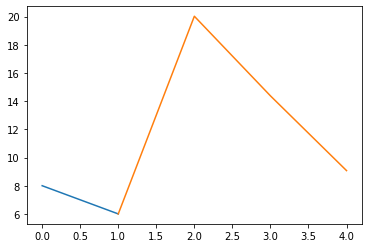

In [126]:
i = 3
x = df_train[df_train.sku_name == df_test.sku_name.unique()[i]]['sellin'].reset_index(drop =True)
y = x.index
x1 = df_test[df_test.sku_name == df_test.sku_name.unique()[i]]['sellin_old'].reset_index(drop =True)
y1 = range(x.index.stop-1, x.index.stop+x1.shape[0]-1)
# y = df_train[df_train.sku_name == df_test.sku_name.unique()[i]]['sellin_old'].reset_index(drop =True)
# plt.plot()
plt.plot(y,x)
plt.plot(y1,x1)
# df_train

In [182]:
# df_test[df_test.sku_name == df_test.sku_name.unique()[i]][['year','month','sellin_old']]
def generate_matrix_cluster(dataframe, n = 300, seed = 42):
    """ Clustering of time series based on dynamic time warp """
    
    np.random.seed(seed)
    matrix = []

    for sku_name in tqdm(sku_names):
        df_ = dataframe.loc[dataframe.sku_name == sku_name, ['time_step', 'sellin']]
        matrix.append(np.array(pd.Series(df_.sellin.values, index=df_.time_step.values)))
        
    matrix = np.matrix(matrix)[:,:,np.newaxis]
    
    return matrix


In [150]:
years = list(range(2016,2022))
ids = df_train.sku_name.unique().tolist()
months = list(range(1,13))

In [176]:
new_frame = pd.DataFrame({'sku_name':np.repeat(ids,len(years)*len(months)),
                         'month':months*len(ids)*len(years),
                         'year':np.repeat(years,len(months)).tolist()*len(ids),
                         'time_step': list(range(len(years)*len(months)))*len(ids)})

In [170]:
# np.repeat(years,len(months)).tolist()

In [173]:
# new_frame.loc[new_frame.sku_name == new_frame.sku_name.unique()[1]]

In [180]:
new_frame = new_frame.sort_values(by = ['sku_name','year','month']).reset_index(drop =True).merge(df_train[['sku_name','year','month','sellin']],how = 'left', on = ['sku_name','year','month']).fillna(0)

In [183]:
# import warnings
# warnings.filterwarnings('ignore')

# from tqdm import tqdm
# import pandas as pd
# import numpy as np
# import itertools
# import pprint
# import random
# import os

# from plotly.offline import iplot, init_notebook_mode
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# import matplotlib.pyplot as plt
# import plotly.express as px
# from plotly import tools
# import plotly.io as pio

# !pip install tslearn
# from tslearn.clustering import TimeSeriesKMeans
# from sklearn.model_selection import KFold

# pp = pprint.PrettyPrinter(indent=4)
# pio.templates.default = "plotly_white"

# from tqdm import tqdm
def run_clustering(matrix):
    """ Perform KMeans on matrix of time series """
    
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
    model.fit(matrix.squeeze())
    
    return model

matrix = generate_matrix_cluster(new_frame)
cluster_p_model = run_clustering(matrix)

100%|██████████████████████████████████████████████████████████████████████████████| 3868/3868 [01:24<00:00, 45.97it/s]


In [148]:
# matrix.squeeze().squeeze().shape
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(matrix)

ValueError: setting an array element with a sequence.

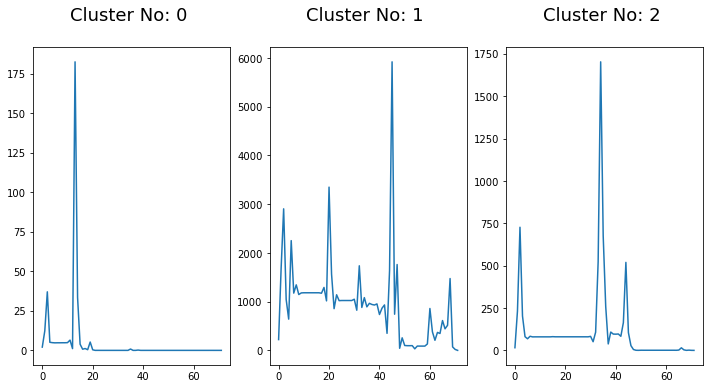

In [184]:
def display_ts_clusters(model, n_clusters=3):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    
    for graph_index in range(n_clusters):
                
        # define subplot
        plt.subplot(330 + 1 + graph_index)
        plt.title('Cluster No: %s \n'%graph_index,
                 fontsize=18)
        
        # plot raw pixel data
        array_cluster = model.cluster_centers_[graph_index]
        pd.Series(array_cluster.ravel()).plot()
        
    plt.subplots_adjust(bottom = 0.001)
    plt.subplots_adjust(top = 1.25)
    plt.show()
    
display_ts_clusters(cluster_p_model)


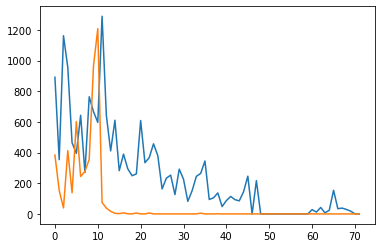

In [202]:
# df_train[df_train.sku_name == df_test.sku_name.unique()[i]][['year','month','sellin','sellin_old']]
# clust =  cluster_p_model.predict(matrix)
# clust = pd.Series(index = ids,data = clust)
new_frame['cluster'] = new_frame['sku_name'].map(clust)
plt.plot(new_frame.loc[new_frame.sku_name == ids[0],'sellin'].values)
plt.plot(new_frame.loc[new_frame.sku_name == ids[2],'sellin'].values)

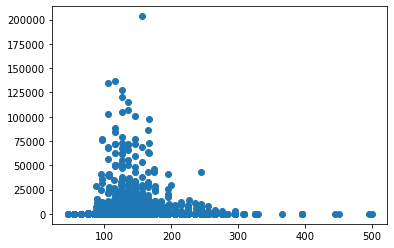

In [223]:
# sns.distplot(new_frame.loc[new_frame.cluster == 2,'sellin'])
# sns.distplot(new_frame.loc[new_frame.cluster == 0,'sellin'])
plt.scatter(#x = df_train.groupby('sku_name').size().values,
           y = df_train.groupby('sku_name')['sellin'].sum().values,
           x = df_train.groupby('sku_name')['price'].mean().values)

In [282]:
def rmspe(y_true, y_pred):
    return  np.mean(np.abs(y_true - y_pred))*1013#(np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true+2)))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),0), False

params = {
      "objective": "mae", 
      "metric": "mae", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
#     'num_leaves': 170,
#     'min_data_in_leaf': 10, 
#     'min_child_weight': 0.066978276178616,
#     'max_depth': 83, 
#     'bagging_fraction': 0.6277904572518515, 
#     'feature_fraction': 0.6965518420559522, 
#     'lambda_l1': 1.6347289329468329, 
#     'lambda_l2': 0.1374430845238362 
}

In [283]:
# df_train1.loc[df_train1.sku_name == df_test.sku_name.values[2]]

In [284]:
# df_test.loc[df_test.sku_name == df_test.sku_name.values[-1]]
# df_test.loc[df_test.period_old.isna(),'period_old'] #= np.array([0,1,2,3])
# df_test['period_old']

In [327]:
kfolds = 10
from sklearn.model_selection import KFold,GroupKFold
kf = KFold(n_splits=kfolds, random_state=1991028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0   

features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})

In [328]:
# df_test

In [329]:
target = 'sellin'
prediction_columns = df_test.columns.tolist()
encoding_columns = [t for t in df_train.columns if t not in prediction_columns]
X = df_train.drop(encoding_columns+[target,'sku_name',
                                    'enc_sku','period_old','product_lifecycle_stage', 'sku_namepriceenc6', 'sku_namepriceenc5', 'sku_namepriceenc4',
       'sku_namepriceenc', 'sku_namepriceenc1', 'sku_namepriceenc2',
       'sku_namepriceenc3', 'sku_nameleftover_inventoryenc6',
       'sku_nameleftover_inventoryenc5', 'sku_nameleftover_inventoryenc4',
       'sku_nameleftover_inventoryenc', 'sku_nameleftover_inventoryenc1',
       'sku_nameleftover_inventoryenc2', 'sku_nameleftover_inventoryenc3',
                                    'sku_namesellinenc6', 'sku_namesellinenc5',
       'sku_namesellinenc4', 'sku_namesellinenc', 'sku_namesellinenc1',
       'sku_namesellinenc2', 'sku_namesellinenc3', 'sku_nameselloutenc6',
       'sku_nameselloutenc5', 'sku_nameselloutenc4', 'sku_nameselloutenc',
       'sku_nameselloutenc1', 'sku_nameselloutenc2', 'sku_nameselloutenc3',],axis=1)
y = df_train[target]

In [330]:
# X.columns.tolist()

In [331]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):#, groups=X["best_month"])):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
#     weights = 1/(w_train)
    lgbm_train = lgbm.Dataset(X_train,y_train)#,weight = weights)

#     weights = 1/(w_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train)#,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=15000,         
#                       feval='mae',
#                     feval=lambda preds, lgbm_train: [feval_RMSE(preds, lgbm_train), 
#                                                   feval_MAPE(preds, lgbm_train),
#                                                      mae(preds, lgbm_train.get_label())
#                                                     ],
                      verbose_eval=100,
#                       categorical_feature = cats                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    oof[val_idx] = y_pred
    features = X_train.columns
    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')
    fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
    fold_importance_df['Feature']= features
    fold_importance_df['Importance']= model.feature_importance()
    fold_importance_df["fold"] = fold + 1
    features_importance = pd.concat([features_importance, fold_importance_df], axis=0)
    #keep scores and models
    scores += RMSPE / kfolds
    models.append(model)
    print("*" * 100)

Fold : 1
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 173.406	valid_1's l1: 164.993
[200]	training's l1: 152.716	valid_1's l1: 146.962
[300]	training's l1: 144.822	valid_1's l1: 140.543
[400]	training's l1: 140.556	valid_1's l1: 137.293
[500]	training's l1: 139.325	valid_1's l1: 136.514
Early stopping, best iteration is:
[541]	training's l1: 139.231	valid_1's l1: 136.458
Performance of the　prediction: , RMSPE: 138232.303
****************************************************************************************************
Fold : 2
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 173.337	valid_1's l1: 166.804
[200]	training's l1: 153.006	valid_1's l1: 146.621
[300]	training's l1: 145.308	valid_1's l1: 138.782
[400]	training's l1: 141.367	valid_1's l1: 135.114
[500]	training's l1: 138.655	valid_1's l1: 132.986
[600]	training's l1: 138.31	valid_1's l1: 132.699
Early stopping, best iteration is:
[570]	training's l1: 138.31

In [332]:
# models = models[10:]
# X.columns

Feature        object
Importance    float64
dtype: object


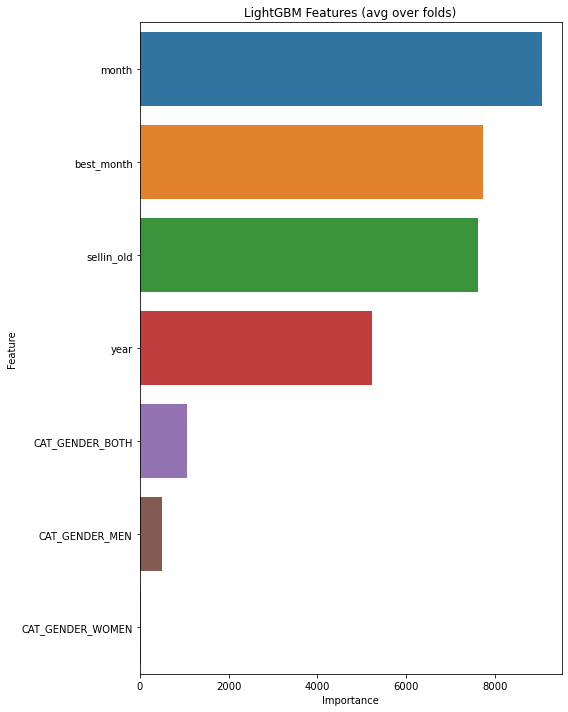

In [333]:
# df_train.best_month.mode()
# from sklearn.model_selection import GroupKFold
# cv = list(GroupKFold(n_splits=10).split(df_train, df_train["sellin"], groups=df_train["best_month"]))
X_test = df_test[X.columns.tolist()].copy()
df_test['Item_ID'] = df_test['sku_name'] +'_'+ df_test['month'].astype(str)+ '_'+df_test['year'].astype(str)
y_pred = df_test[['Item_ID']]
target = np.zeros(len(X_test))
target2 = np.zeros(len(X_test))
#light gbm models
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)
y_pred = y_pred.assign(target_y= target)
sub = ss.merge(y_pred,on = 'Item_ID')
sub['target'] = sub['target_y'].round()*1013
# sub['target'] = (sub['target'].astype('int') )
sub = sub[['Item_ID','target']]
display_importances(features_importance)


In [334]:
sub

,Item_ID,target
0,YOSHTLYNYOSHZZ_11_2021,95222.0
1,YOSHTLYNYOSHZZ_12_2021,208678.0
2,YOSHTLYNYOSHZZ_1_2022,255276.0
3,YOSHTLYNYOSHZZ_2_2022,731386.0
4,YOSHRENECARL_11_2021,174236.0
...,...,...
1523,ABEENNEARMAZZ_2_2022,668580.0
1524,ABEAHAMASHL_11_2021,15195.0
1525,ABEAHAMASHL_12_2021,95222.0
1526,ABEAHAMASHL_1_2022,54702.0


In [335]:
sub.to_csv('submission_70.csv',index = False)

In [ ]:
X_test = df_test[X.columns.tolist()].copy()

In [320]:
193989.5/1013

191.5

In [ ]:
import lightgbm as lgb
# from sklearn.model selection import 
def fit_predict(n_splits, params, x_train = X, y_train = y, x_test = X_test):
    
    oof = np.zeros(x_train.shape[0])
    
    y_preds = []
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=1991028)
    for train_idx, valid_idx in cv.split(x_train, y_train):
        
        x_train_train = x_train.iloc[train_idx]
        y_train_train = y_train.iloc[train_idx]
        x_train_valid = x_train.iloc[valid_idx]
        y_train_valid = y_train.iloc[valid_idx]

        lgb_train = lgb.Dataset(data=x_train_train.astype('float32'), label=y_train_train.astype('float32'))
        lgb_valid = lgb.Dataset(data=x_train_valid.astype('float32'), label=y_train_valid.astype('float32'))

        estimator = lgb.train(params, lgb_train, 15000, valid_sets=lgb_valid,
                              early_stopping_rounds=30, verbose_eval=-1)

        oof_part = estimator.predict(x_train_valid, num_iteration=estimator.best_iteration)
        oof[valid_idx] = oof_part
        
        if x_test is not None:
            y_part = estimator.predict(x_test, num_iteration=estimator.best_iteration)
            y_preds.append(y_part)
        
    score = rmspe(y_train, oof)
    print('Score:', score)
    
    y_pred = np.mean(y_preds, axis=0)
    
    return y_pred, oof, score
## Optuna
import optuna


columns_to_try = ['sellin']

def objective(trial):
    
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
#         'boost_from_average': True,
        'num_threads': 4,
        'random_state': 25031991,
        'learning_rate': 0.025,
        'verbose': -1,
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'bagging_fraction': trial.suggest_loguniform('bagging_fraction', .5, .99),
        'feature_fraction': trial.suggest_loguniform('feature_fraction', .5, .99),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 2),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 2)
    }
    
#     scores = []
#     for column in columns_to_try:
    _ ,_ , score = fit_predict(10, params, X, y, X_test)
#         scores.append(score)
    
    return score



In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

In [ ]:
# {'num_leaves': 170, 'min_data_in_leaf': 10, 'min_child_weight': 0.066978276178616, 'max_depth': 83, 'bagging_fraction': 0.6277904572518515, 'feature_fraction': 0.6965518420559522, 'lambda_l1': 1.6347289329468329, 'lambda_l2': 0.1374430845238362}